# Analysing Elo rating development in biased scenarios

Python 3.9.12

## Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import annotations

## Set seed

In [2]:
seed = 2

# Player Class Documentation

## Class Description
The `Player` class models a chess player, encapsulating attributes and behaviors such as Elo rating, potential engine use for cheating, and sandbagging behavior.

## Class Attributes
- `engine_use_default_probability`: `float`
  - Default probability of a player using a chess engine when their Elo loss does not meet any specified thresholds.
- `engine_use_probability_thresholds`: `dict`
  - A dictionary mapping Elo loss percentages to the corresponding probabilities of a player using a chess engine.
- `engine_advantage_factor`: `int`
  - The factor representing the percentage increase in win probability when a player uses a chess engine.
- `sandbagging_elo_mean`: `int`
  - The mean Elo rating for players who engage in sandbagging.
- `sandbagging_elo_std`: `float`
  - The standard deviation for the Elo rating of sandbagging players.
- `sandbagging_reset_rate`: `float`
  - The probability rate at which a sandbagging player's Elo rating resets to their original rating after each game.

## Constructor
### `__init__(self, name, elo, is_engine_user, is_sandbagger)`
Initializes a new instance of the `Player` class.
- `name`: `str` - The name of the player.
- `elo`: `int` - The Elo rating of the player.
- `is_engine_user`: `bool` - Indicates whether the player uses a chess engine.
- `is_sandbagger`: `bool` - Indicates whether the player is a sandbagger.

## Instance Attributes
- `name`: `str` - The name of the player.
- `elo_group`: `int` - The current group Elo rating of the player.
- `game_counter`: `int` - The number of games played by the player.
- `is_sandbagger`: `bool` - Indicates whether the player is a sandbagger.
- `is_engine_user`: `bool` - Indicates whether the player uses a chess engine.
- `learning_rate`: `float` - The rate at which the player's skill improves naturally.
- `elo_absolute`: `int` - The absolute Elo rating of the player, different for sandbaggers.
- `__elo_original`: `int` - The original Elo rating of the player, which remains constant.

## Methods
### `is_winner(self, competitor)`
Determines the outcome of a game against a competitor.
- `competitor`: `Player` - The opponent in the game.
- Returns: `bool` - True if the player wins the game, False otherwise. The probability is adjusted based on engine use by either player.

### `set_elo(self, elo_increment)`
Updates the player's Elo ratings.
- `elo_increment`: `int` - The increment (positive or negative) to be added to the player's Elo ratings.

### `set_parameters_post_game(self)`
Updates the player's game counter and potentially resets the Elo rating for sandbaggers.
- This method is called after a game to update the player's status.

### `engine_use_probability(self)`
Calculates the probability of the player using a chess engine based on their Elo loss.
- Returns: `float` - The probability of the player using a chess engine.

### `calculate_elo_increment(rating1, rating2, result, K=32)`
A static method to calculate the Elo rating changes for two players after a game.
- `rating1`: `int` - The Elo rating of the first player.
- `rating2`: `int` - The Elo rating of the second player.
- `result`: `float` - The game result from the perspective of the first player (1 for win, 0 for loss, 0.5 for draw).
- `K`: `int` - The K-factor used in Elo rating calculations.
- Returns: `tuple` - A tuple containing the Elo rating increments for both players.

In [3]:
class Player:
    
    engine_use_default_probability = 0.3
    engine_use_probability_thresholds = {0.05: 0.5, 0.10: 0.75, 0.15: 1.00}
    engine_advantage_factor = 3  # +x% increase in win probability
    
    sandbagging_elo_mean = 1600
    sandbagging_elo_std = 1600 * 0.1
    sandbagging_reset_rate = 0.01
    
    def __init__(self, name: str, elo: int, is_engine_user: bool, is_sandbagger: bool):
        self.name = name
        self.elo_group = elo
        self.game_counter = 0
        self.is_sandbagger = is_sandbagger
        self.is_engine_user = is_engine_user
        self.learning_rate = np.abs(np.random.normal(0.5, 0.2))
        if is_sandbagger:
            self.elo_absolute = np.random.normal(self.sandbagging_elo_mean, self.sandbagging_elo_std)
        else:
            self.elo_absolute = elo
        self.__elo_original = elo  # will never change
            
    def is_winner(self, competitor: Player): 
        
        # Determine engine use
        ## Player
        if self.is_engine_user:
            player_uses_engine = self.engine_use_probability() > np.random.random()
        else:
            player_uses_engine = False
        ## Competitor
        if competitor.is_engine_user:
            competitor_uses_engine = competitor.engine_use_probability() > np.random.random()
        else:
            competitor_uses_engine = False
        
        # Determine win probability
        elo_difference = competitor.elo_absolute - self.elo_absolute
        base_win_probability = 1 / (1 + 10 ** (elo_difference / 400))
        
        # Determine winner
        if not player_uses_engine and competitor_uses_engine:
            adjusted_win_probability = max(base_win_probability * (1 / self.engine_advantage_factor), 0)
            return np.random.random() <= adjusted_win_probability
        elif player_uses_engine and not competitor_uses_engine:
            adjusted_win_probability = min(base_win_probability * self.engine_advantage_factor, 1)
            return np.random.random() <= adjusted_win_probability
        else:
            # Neither or both are engine users
            return np.random.random() <= base_win_probability

    def set_elo(self, elo_increment: int):
        self.elo_group += elo_increment
        self.elo_absolute += self.learning_rate
            
    def set_parameters_post_game(self):
        self.game_counter =+ 1
        if self.is_sandbagger and np.random.random() <= self.sandbagging_reset_rate:
            self.elo_group = self.__elo_original
            
    def engine_use_probability(self):
        elo_loss_percentage = (self.__elo_original - self.elo_group) / self.__elo_original
        for threshold, probability in sorted(self.engine_use_probability_thresholds.items(), reverse=True):
            if elo_loss_percentage >= threshold:
                return probability
        return self.engine_use_default_probability
    
    @staticmethod
    def calculate_elo_increment(rating1, rating2, result, K=32):
        expected_score1 = 1 / (1 + 10 ** ((rating2 - rating1) / 400))
        expected_score2 = 1 / (1 + 10 ** ((rating1 - rating2) / 400))
        new_rating1 = K * (result - expected_score1)
        new_rating2 = K * (1 - result - expected_score2)
        return new_rating1, new_rating2

## Simulation

In [4]:
elo_start = 800
n_players = 1000
cheater_ratio = 0.1
n_cheaters = int(n_players * cheater_ratio / 2)
n_sandbaggers = int(n_players * cheater_ratio / 2)
np.random.seed(seed)

players = []
for i in range(n_players - n_cheaters - n_sandbaggers):
    players.append(Player(name='Player_' + str(i), elo=elo_start, is_engine_user=False, is_sandbagger=False))
    
for i in range(n_cheaters):
    players.append(Player(name='Cheater_' + str(i), elo=elo_start, is_engine_user=True, is_sandbagger=False))
    
for i in range(n_sandbaggers):
    players.append(Player(name='Sandbagger_' + str(i), elo=elo_start, is_engine_user=False, is_sandbagger=True))

In [5]:
n_games = 500
np.random.seed(seed)

elo_group_all_means = []
elo_group_qls_means = []
elo_abs_all_means = []
elo_abs_qls_means = []

elo_group_all_means_wCheaters = []
elo_group_qls_means_wCheaters = []
elo_abs_all_means_wCheaters = []
elo_abs_qls_means_wCheaters = []

for _ in range(n_games):
    np.random.shuffle(players)
    for i in range(0, len(players), 2):
        if i + 1 < len(players):
            p1 = players[i]
            p2 = players[i + 1]
            if p1.is_winner(p2):
                p1_incr, p2_incr = Player.calculate_elo_increment(p1.elo_group, p2.elo_group, 1)
            else:
                p1_incr, p2_incr = Player.calculate_elo_increment(p1.elo_group, p2.elo_group, 0)
            p1.set_elo(p1_incr)
            p2.set_elo(p2_incr)
            p1.set_parameters_post_game()
            p2.set_parameters_post_game()

    # Group Elo w/o cheaters
    # ----------------------
    # All players
    elo_group_all = [player.elo_group for player in players 
                     if not player.is_engine_user and not player.is_sandbagger]
    elo_group_all_means.append(np.mean(elo_group_all))
    # Quick learners
    elo_group_qls = [player.elo_group for player in players 
                     if not player.is_engine_user and not player.is_sandbagger and player.learning_rate >= 0.8]
    elo_group_qls_means.append(np.mean(elo_group_qls))
    
    # Absolue Elo w/o cheaters
    # ------------------------
    # All players
    elo_abs_all = [player.elo_absolute for player in players if not player.is_engine_user and not player.is_sandbagger]
    elo_abs_all_means.append(np.mean(elo_abs_all))
    # Quick learners
    elo_abs_qls = [player.elo_absolute for player in players if not player.is_engine_user and not player.is_sandbagger and player.learning_rate >= 0.8]
    elo_abs_qls_means.append(np.mean(elo_abs_qls))
    
    if n_cheaters > 0:
        
        # Group Elo w/ cheaters
        # ----------------------
        # All players
        elo_group_all_wCheaters = [player.elo_group for player in players]
        elo_group_all_means_wCheaters.append(np.mean(elo_group_all_wCheaters))
        # Quick learners
        elo_group_qls_wCheaters = [player.elo_group for player in players if player.learning_rate >= 0.8]
        elo_group_qls_means_wCheaters.append(np.mean(elo_group_qls_wCheaters))

        # Absolue Elo w cheaters
        # ------------------------
        # All players
        elo_abs_all_wCheaters = [player.elo_absolute for player in players]
        elo_abs_all_means_wCheaters.append(np.mean(elo_abs_all_wCheaters))
        # Quick learners
        elo_abs_qls_wCheaters = [player.elo_absolute for player in players if player.learning_rate >= 0.8]
        elo_abs_qls_means_wCheaters.append(np.mean(elo_abs_qls_wCheaters))

## Analysis

In [6]:
def plot_dist_kde(vector1, header1, vector2=None, header2=None, xlab="", ylab="", color1='blue', color2='red'):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(vector1, color=color1, label=header1, fill=True)
    if vector2 is not None:
        sns.kdeplot(vector2, color=color2, label=header2, fill=True)
    
    plt.title(f"Distribution of Group Elo: {header1} vs {header2}" if header2 else header1)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)
    if vector2 is not None:
        plt.legend()
    plt.show()

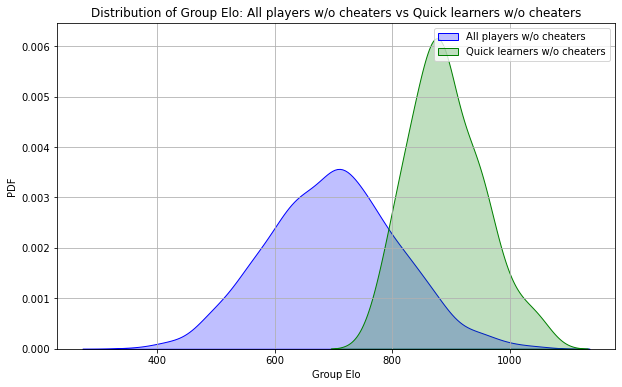

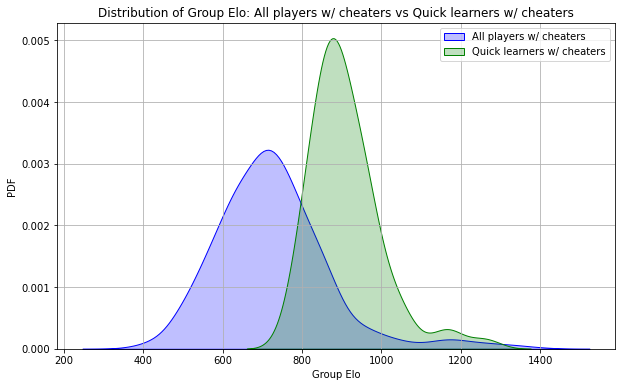

In [7]:
plot_dist_kde(elo_group_all, 'All players w/o cheaters', 
              elo_group_qls, 'Quick learners w/o cheaters',
              'Group Elo', 'PDF', 'blue', 'green')

if n_cheaters > 0:
    plot_dist_kde(elo_group_all_wCheaters, 'All players w/ cheaters', 
                  elo_group_qls_wCheaters, 'Quick learners w/ cheaters',
                  'Group Elo', 'PDF', 'blue', 'green')

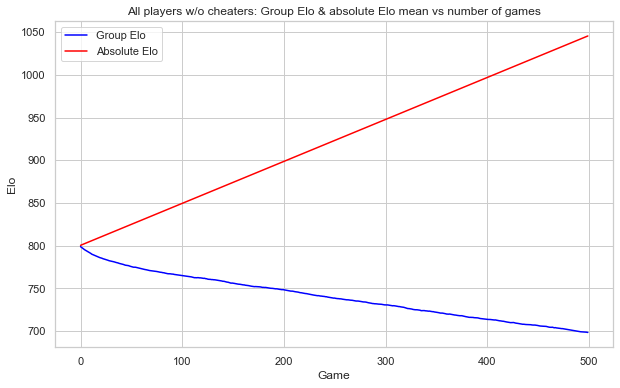

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(elo_group_all_means, label='Group Elo', color='blue', marker='')
plt.plot(elo_abs_all_means, label='Absolute Elo', color='red', marker='')
plt.title('All players w/o cheaters: Group Elo & absolute Elo mean vs number of games')
plt.xlabel('Game')
plt.ylabel('Elo')
plt.legend()
plt.show()

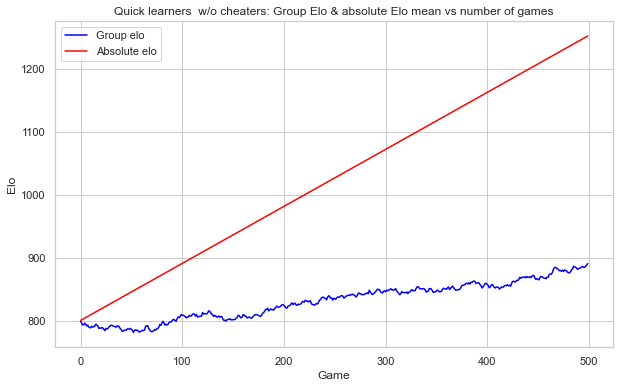

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(elo_group_qls_means, label='Group elo', color='blue', marker='')
plt.plot(elo_abs_qls_means, label='Absolute elo', color='red', marker='')
plt.title('Quick learners  w/o cheaters: Group Elo & absolute Elo mean vs number of games')
plt.xlabel('Game')
plt.ylabel('Elo')
plt.legend()
plt.show()